# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [1]:
%matplotlib inline
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

matplotlib.style.use('ggplot')

## Reading input data

In [2]:
sqlContext = SQLContext(sc)

df_telemetry = sqlContext.read.parquet('data/telemetry')
df_logs = sqlContext.read.parquet('data/logs')

df_telemetry.printSchema()
df_logs.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- machineID: string (nullable = true)
 |-- pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- speed_desired: long (nullable = true)
 |-- temperature: double (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- code: string (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)



In [3]:
print(df_telemetry.count())
print(df_logs.count())

24487553
683


## Data exploration

In [4]:
machineID = df_logs.first().machineID

machine_sequence_df = df_telemetry.where(df_telemetry.machineID == machineID).orderBy(df_telemetry.timestamp)
machine_sequence_df.persist(StorageLevel.MEMORY_ONLY)
pdf = machine_sequence_df.toPandas()
pdf.set_index('timestamp', inplace=True)
pdf.describe()

,ambient_pressure,ambient_temperature,pressure,speed,speed_desired,temperature
count,5311.000000,5311.000000,5311.000000,5311.000000,5311.0,5311.000000
mean,101.000128,20.000444,821.208157,999.845263,1000.0,156.676287
std,0.058225,0.058283,139.458385,8.394249,0.0,9.254828
min,100.900000,19.900000,136.280000,501.520000,1000.0,25.040000
25%,100.950000,19.950000,751.010000,997.510000,1000.0,150.850000
50%,101.000000,20.000000,860.200000,1000.030000,1000.0,154.080000
75%,101.050000,20.050000,928.690000,1002.510000,1000.0,159.900000
max,101.100000,20.100000,996.310000,1005.000000,1000.0,214.890000


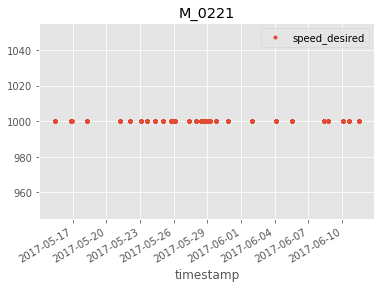

In [5]:
pdf.plot(title=machineID , style=".", y='speed_desired')

## Feature creation

### Operational cycles

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01e3787860>,
      dtype=object)

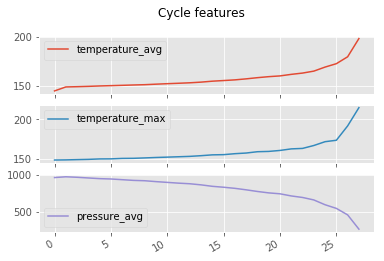

In [14]:
def cycles(df):
    w = Window.partitionBy('machineID').orderBy('timestamp')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(F.unix_timestamp('timestamp') - F.unix_timestamp(F.lag('timestamp', 1).over(w)), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > 30).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.avg('speed').alias('speed_avg'),
        F.avg('temperature').alias('temperature_avg'),
        F.max('temperature').alias('temperature_max'),
        F.avg('pressure').alias('pressure_avg'),
        F.min('timestamp').alias('cycle_start'),
        F.max('timestamp').alias('cycle_end')
    ).orderBy('cycle')

msdf_cycles = cycles(machine_sequence_df)
msdf_cycles[['temperature_avg', 'temperature_max', 'pressure_avg']].toPandas().plot(subplots=True, title='Cycle features')

In [8]:
cycles_df = cycles(df_telemetry)
cycles_df.persist(StorageLevel.MEMORY_AND_DISK)
cycles_df.count()

136485

### Augmenting data with additional lag features

### Labeling

In [16]:
#df_logs.show()

w = Window.partitionBy('machineID', 'level', 'code').orderBy('timestamp') # since last failure of the same type?
diff = F.coalesce(F.lag('timestamp', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failures_df = (df_logs.where(df_logs.level == 'CRITICAL')
               .withColumn('last_failure_timestamp', diff)
               .withColumnRenamed('timestamp', 'failure_timestamp')
               .withColumnRenamed('code', 'failure')
               .drop('level'))

labeled_cycles_df = (cycles_df.join(failures_df,
                                       (cycles_df.machineID == failures_df.machineID) &
                                       (cycles_df.cycle_start >= failures_df.last_failure_timestamp) &
                                       (cycles_df.cycle_end <= failures_df.failure_timestamp),
                                       'left_outer')
                     .drop(failures_df.machineID)
                     .drop(cycles_df.cycle_start)
                     .drop(cycles_df.cycle_end)
                     .drop(failures_df.last_failure_timestamp)
                     .withColumn(
                         'rul',
                         F.dense_rank().over(Window.partitionBy('machineID', 'failure_timestamp')
                                             .orderBy(F.desc('cycle'))))
                     .drop(failures_df.failure_timestamp))

In [18]:
labeled_cycles_df.limit(10).toPandas().head()

,machineID,cycle,speed,temperature,temperature_max,pressure,failure,rul
0,M_0121,173,1000.006636,189.467727,214.95,363.070091,F1,1
1,M_0121,172,999.707083,178.061000,181.56,486.870583,F1,2
2,M_0121,171,999.789417,173.273333,175.20,547.044417,F1,3
3,M_0121,170,1000.112792,169.062958,171.62,606.547583,F1,4
4,M_0121,169,1000.292000,166.120500,166.98,648.603750,F1,5


In [19]:
labeled_cycles_df.where(labeled_cycles_df.failure.isNotNull()).groupBy('machineID').agg(F.max('rul')).toPandas().describe()

,max(rul)
count,683.000000
mean,110.973646
std,50.136025
min,27.000000
25%,69.000000
50%,108.000000
75%,153.000000
max,226.000000


## Persisting the labeled feature dataset

In [23]:
% rm -rf data/features

labeled_cycles_df.coalesce(5).write.csv('data/features', header=True)

## References
http://waset.org/publications/10006640/building-a-scalable-telemetry-based-multiclass-predictive-maintenance-model-in-r
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.386.8108&rep=rep1&type=pdf